In [24]:
%pylab inline

import os
import sys
import random
import pstats

from collections import defaultdict
from profile import Profile as PythonProfiler

import pandas as pd
import seaborn as sns
import hippiehug

from msgpack import packb

sys.path.append('..')

from claimchain import State, View, LocalParams
from claimchain.core import encode_claim
from claimchain.utils.wrappers import serialize_object, Blob
from claimchain.utils.profiling import Profiler, profiled

Populating the interactive namespace from numpy and matplotlib


/home/bogdan/Workspace/claimchain-core/venv/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
sns.set_context("paper", font_scale=1.75)
sns.set_style("white")
sns.set_palette('colorblind', n_colors=5)

In [4]:
sys.version

'3.5.2 (default, Nov 17 2016, 17:05:23) \n[GCC 5.4.0 20160609]'

## Generating test data

This simulates `nb_readers` readers, each with own set of cryptographic keys. Every reader gets a random **32 byte** label associated with them, and **512 bytes** randomly generated claim about them.

The random capability matrix is generated: for each of the target readers _t_, `nb_caps_per_reader` other readers are randomly chosen. These are the ones that the reader _t_ will be able to access claims about, i.e. be included in _t_'s capability list.



In [6]:
def generate_test_data(nb_readers=1000, nb_caps_per_reader=1, label_size=32, claim_size=512):
    labels = [b'label_' + os.urandom(label_size - 6) for _ in range(nb_readers)]
    claims = [b'claim_' + os.urandom(claim_size - 6) for _ in range(nb_readers)]

    params = [LocalParams.generate() for _ in range(nb_readers)]

    reader_graph = {}
    for reader_index in range(nb_readers):
        cap = random.sample(range(nb_readers), nb_caps_per_reader)
        reader_graph[reader_index] = cap

    return reader_graph, labels, claims, params

## Simulating the owner
The owner builds a state consisting of the claims generated above, with the access capabilities as generated above. The state is committed to the chain.

In [7]:
def commit_claims(reader_graph, labels, claims, params):
    owner_params = LocalParams.generate()
    with owner_params.as_default():
        state = State()
        
        # Add claims
        for label, claim in zip(labels, claims):
            state[label] = claim
        
        # Define the capability lists
        for reader_index, cap_indexes in reader_graph.items():
            reader_dh_pk = params[reader_index].dh.pk
            cap_labels = [labels[cap_index] for cap_index in cap_indexes]
            state.grant_access(reader_dh_pk, cap_labels)
        
        # Commit
        chain = hippiehug.Chain()
        state.commit(target_chain=chain)

        return chain, state

## Compute evidence

Evidence of claim inclusion can be done either on the owner's side or on the client's side depending on the setting. We measure the size of evidence paths.

In [9]:
@profiled
def compute_single_evidence_path(tree, lookup_key):
    root, evidence = tree.evidence(lookup_key)
    assert evidence[-1].key == lookup_key
    return evidence
        
def compute_random_evidences(state, nb_samples=200):
    assert hasattr(state, '_enc_items_map')
    tree = state._tree
    evidence_map = {}
    for lookup_key in random.sample(list(state._enc_items_map), nb_samples):
        evidence_map[lookup_key] = \
                compute_single_evidence_path(tree, lookup_key)
    return evidence_map

def serialize_evidence(evidence):
    return packb([serialize_object(node) for node in evidence])

## Simulating the readers

In [10]:
def read_claims(chain, reader_graph, labels, claims, params):
    # Go over all of the readers
    view = View(chain)
    for reader_index, caps_indexes in reader_graph.items():
        reader_params = params[reader_index]
        with reader_params.as_default():
            # Retrieve each of the accessible labels
            for cap_index in caps_indexes:
                label = labels[cap_index]
                read_claim = view[labels[cap_index]]
                
                # Check the value matches original to be sure
                assert read_claim == claims[cap_index]
    return view

## Storage measurements

Sizes of claim sets to be simulated

In [11]:
nb_claims_range = range(100, 6000, 500)
list(nb_claims_range)

[100, 600, 1100, 1600, 2100, 2600, 3100, 3600, 4100, 4600, 5100, 5600]

In [172]:
evidence_length_data = pd.DataFrame(columns=('avg', 'std'))
evidence_size_data = pd.DataFrame(columns=('avg', 'std'))
evidence_timing_data = pd.DataFrame(columns=('avg', 'std'))
store_snapshots = []

for nb_claims in nb_claims_range:
    reader_graph, labels, claims, params = generate_test_data(
        nb_readers=nb_claims, nb_caps_per_reader=1)
    
    # Commit claims
    chain, state = commit_claims(reader_graph, labels, claims, params)
    # Compute evidence of inclusion for each claims
    profiler = Profiler()
    with profiler.as_default():
        evidence_map = compute_random_evidences(state, nb_samples=200)
        stats = profiler.compute_stats()['compute_single_evidence_path']
        evidence_timing_data.loc[nb_claims] = (stats['avg'], stats['std'])
    
    evidence_lengths = np.array([len(evidence) for evidence in evidence_map.values()])
    evidence_length_data.loc[nb_claims] = (evidence_lengths.mean(), evidence_lengths.std())

    evidence_sizes = np.array([len(serialize_evidence(evidence)) for evidence in evidence_map.values()])
    evidence_size_data.loc[nb_claims] = (evidence_sizes.mean(), evidence_sizes.std())
    
    store_snapshots.append(chain.store.copy())

Evidence size

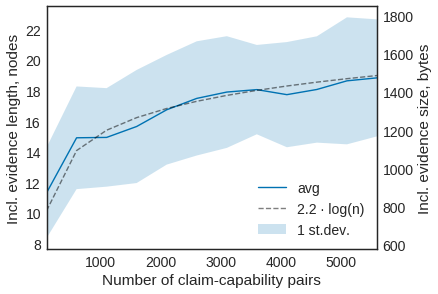

In [276]:
fig, ax1 = plt.subplots()
ax1.plot(nb_claims_range, evidence_length_data['avg'])
ax1.fill_between(nb_claims_range,
                 evidence_length_data['avg'] - evidence_length_data['std'],
                 evidence_length_data['avg'] + evidence_length_data['std'],
                 alpha=.2,
                 label='1 st.dev.')
constant = 2.2
ax1.plot(nb_claims_range, constant * np.log(nb_claims_range),
         color='black', alpha=.5, linestyle='--', label='%1.1f · log(n)' % constant)
ax1.set_xlabel('Number of claim-capability pairs')
ax1.set_ylabel('Incl. evidence length, nodes')
ax1.legend(loc=4)

ax2 = ax1.twinx()

# Plots happen to almost coincide on this scale, so setting alpha to zero.
# Only plotting the invisible lines to show the right (bytes) scale.
ax2.plot(nb_claims_range, evidence_size_data['avg'],
         color='red', alpha=0)
ax2.fill_between(nb_claims_range,
                 evidence_size_data['avg'] - evidence_size_data['std'],
                 evidence_size_data['avg'] + evidence_size_data['std'],
                 color='red', alpha=0)
ax2.set_ylabel('Incl. evidence size, bytes')
plt.xlim(100, 5600)

fig.tight_layout()

plt.savefig('evidence_size.pdf')

Evidence timing

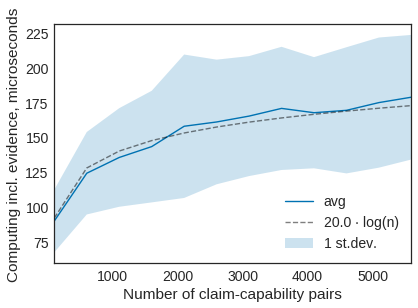

In [277]:
evidence_timing_data_ms = evidence_timing_data * 10e+6
plt.plot(nb_claims_range, evidence_timing_data_ms['avg'])
plt.fill_between(nb_claims_range,
                 evidence_timing_data_ms['avg'] - evidence_timing_data_ms['std'],
                 evidence_timing_data_ms['avg'] + evidence_timing_data_ms['std'],
                 alpha=.2,
                 label='1 st.dev.')
constant = 20
plt.plot(nb_claims_range, constant * np.log(nb_claims_range),
         color='black', alpha=.5, linestyle='--', label='%1.1f · log(n)' % constant)
plt.legend(loc=4)
plt.xlabel('Number of claim-capability pairs')
plt.xlim(100, 5600)
plt.ylabel('Computing incl. evidence, microseconds')

plt.savefig('evidence_timing.pdf')

In [ ]:
build_tree_timing_data = pd.DataFrame(columns=['avg', 'std'])
store_snapshots_1 = []

for nb_claims in nb_claims_range:
    print(nb_claims)
    # Commit claims
    profiler = Profiler()
    reader_graph, labels, claims, params = generate_test_data(
        nb_readers=nb_claims, nb_caps_per_reader=1)
    stats_per_iteration = []
    for n in range(20):
        with profiler.as_default():
            chain, state = commit_claims(reader_graph, labels, claims, params)
            stats = profiler.compute_stats()
            stats_per_iteration.append(stats)
    timings = np.array([stats['_build_tree']['avg'] for stats in stats_per_iteration])
    build_tree_timing_data.loc[nb_claims] = (np.mean(timings), np.std(timings))
    
    store_snapshots_1.append(chain.store.copy())

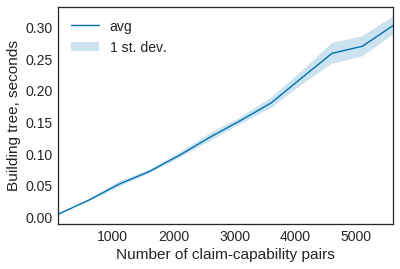

In [82]:
plt.plot(nb_claims_range, build_tree_timing_data_sec['avg'])
plt.fill_between(nb_claims_range,
                 build_tree_timing_data['avg'] - build_tree_timing_data['std'],
                 build_tree_timing_data['avg'] + build_tree_timing_data['std'],
                 alpha=.2,
                 label='1 st. dev.')

plt.legend(loc=2)
plt.xlabel('Number of claim-capability pairs')
plt.xlim(100, 5600)
plt.ylabel('Building tree, seconds')

plt.savefig('tree_build_timing.pdf')

Comparing the current timing for build the tree vs. inefficient one.

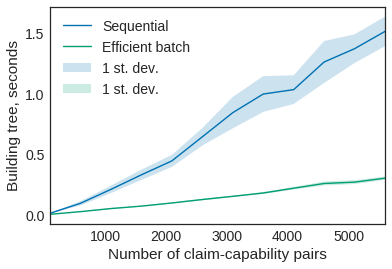

In [83]:
import pickle
with open('build_tree_timing_data.pkl', 'rb') as f:
    old_build_tree_timing_data = pickle.load(f)

plt.plot(nb_claims_range, old_build_tree_timing_data['avg'], label='Sequential')
plt.plot(nb_claims_range, build_tree_timing_data['avg'], label='Efficient batch')
plt.fill_between(nb_claims_range,
                 old_build_tree_timing_data['avg'] - old_build_tree_timing_data['std'],
                 old_build_tree_timing_data['avg'] + old_build_tree_timing_data['std'],
                 alpha=.2,
                 label='1 st. dev.')
plt.fill_between(nb_claims_range,
                 build_tree_timing_data['avg'] - build_tree_timing_data['std'],
                 build_tree_timing_data['avg'] + build_tree_timing_data['std'],
                 alpha=.2,
                 label='1 st. dev.')

plt.legend(loc=2)
plt.xlabel('Number of claim-capability pairs')
plt.xlim(100, 5600)
plt.ylabel('Building tree, seconds')
plt.show()

In [64]:
def is_leaf(obj):
    return isinstance(obj, hippiehug.Nodes.Leaf)
    
def is_node(obj):
    return isinstance(obj, hippiehug.Nodes.Branch)

def is_block(obj):
    return isinstance(obj, hippiehug.Block)
    
def is_blob(obj):
    return isinstance(obj, Blob)

def calc_objects_size(filter_fn, store):
    return sum(len(packb(serialize_object(obj))) for obj in filter(filter_fn, store.values()))

current_store_snapshots = store_snapshots_1
sizes_data = pd.DataFrame(columns=['Encrypted blobs', 'Tree nodes', 'Tree leaves', 'Block'])

for nb_claims, snapshot in zip(nb_claims_range, current_store_snapshots):
    sizes_data.loc[nb_claims] = (
        calc_objects_size(is_blob, snapshot),
        calc_objects_size(is_node, snapshot),
        calc_objects_size(is_leaf, snapshot),
        calc_objects_size(is_block, snapshot))
sizes_data

,Encrypted blobs,Tree nodes,Tree leaves,Block
100,66500,26080,9000,484
600,398997,159680,54000,484
1100,731490,292800,99000,484
1600,1063986,427040,144000,484
2100,1396485,560960,189000,484
2600,1728972,692240,234000,484
3100,2061468,826240,279000,483
3600,2393973,960240,324000,484
4100,2726475,1096560,369000,484
4600,3058966,1225600,414000,484


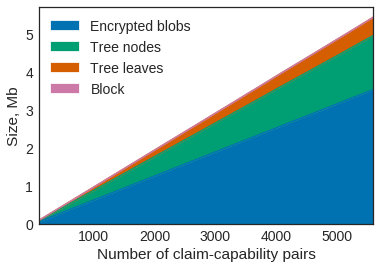

In [84]:
unit = 1 / (1024. * 1024.)
sizes_data_mb = sizes_data * unit
sizes_data_mb.plot.area()

plt.xlabel('Number of claim-capability pairs')
plt.ylabel('Size, Mb')
plt.savefig('storage_size.pdf')

## Timing core operations

In [66]:
def simulate():
    reader_graph, labels, claims, params = generate_test_data()

    # Commit claims
    chain, state = commit_claims(reader_graph, labels, claims, params)
    # Simulate readers
    view = read_claims(chain, reader_graph, labels, claims, params)
    # Compute evidence of inclusion for each claim
    evidence_map = compute_random_evidences(state, 2000)

### High-level profiling

In [67]:
profiler = Profiler()
with profiler.as_default():
    simulate()
    stats = profiler.compute_stats()

In [68]:
df = pd.DataFrame(stats)
df = df.T
stat_cols = ['avg', 'max', 'min', 'std']
df = df[stat_cols].apply(lambda value: value * 1000)  # milliseconds
df = df.round(2)
df

,avg,max,min,std
_build_tree,40.55,40.55,40.55,NaN
compute_single_evidence_path,0.01,0.17,0.01,0.01
compute_vrf,1.47,3.16,1.06,0.20
decode_capability,0.14,0.57,0.13,0.03
decode_claim,2.56,6.29,1.92,0.42
encode_capability,0.14,0.18,0.13,0.00
encode_claim,1.52,3.27,1.11,0.20
get_capability_lookup_key,0.12,0.40,0.11,0.02
verify_vrf,2.52,6.20,1.88,0.41


In [69]:
pretty_df = df[['avg', 'std']].sort_index()
readable_procedure_names = {
    '_build_tree': 'Tree construction',
    'compute_single_evidence_path': 'Single entry inclusion proof computation',
    'compute_vrf': 'VRF computation',
    'decode_capability': 'Single-label capab. decoding',
    'decode_claim': 'Claim decoding',
    'encode_capability': 'Single-label capab. encoding',
    'encode_claim': 'Claim encoding',
    'get_capability_lookup_key': 'Single-label capab. lookup key computation',
    'verify_vrf': 'VRF verification',
}
pretty_df.index = [readable_procedure_names[func_name] for func_name in pretty_df.index]
pretty_df.sort_values(by='avg', inplace=True)
pretty_df.columns = ['avg (ms)', 'std']
print(pretty_df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  avg (ms) &   std \\
\midrule
Single entry inclusion proof computation   &      0.01 &  0.01 \\
Single-label capab. lookup key computation &      0.12 &  0.02 \\
Single-label capab. decoding               &      0.14 &  0.03 \\
Single-label capab. encoding               &      0.14 &  0.00 \\
VRF computation                            &      1.47 &  0.20 \\
Claim encoding                             &      1.52 &  0.20 \\
VRF verification                           &      2.52 &  0.41 \\
Claim decoding                             &      2.56 &  0.42 \\
Tree construction                          &     40.55 &   NaN \\
\bottomrule
\end{tabular}



### Low-level profiling

Full simulation

In [70]:
profiler = PythonProfiler()
profiler.runctx("simulate()", globals(), locals())
profiler.create_stats()

profiler.print_stats(sort='cumtime')

         1696094 function calls (1606794 primitive calls) in 8.275 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    8.275    8.275 profile:0(simulate())
        1    0.000    0.000    8.275    8.275 :0(exec)
        1    0.014    0.014    8.275    8.275 <string>:1(<module>)
        1    0.000    0.000    8.241    8.241 <ipython-input-66-92a6c275a10b>:1(simulate)
9001/7001    0.072    0.000    7.212    0.001 profiling.py:34(wrapped)
        1    0.011    0.011    4.354    4.354 <ipython-input-10-55663c6fc6b2>:1(read_claims)
     1000    0.005    0.000    4.306    0.004 state.py:197(__getitem__)
     1000    0.007    0.000    3.556    0.004 state.py:187(_lookup_claim)
     1000    0.023    0.000    3.415    0.003 core.py:68(decode_claim)
     1000    0.052    0.000    3.165    0.003 vrf.py:37(verify_vrf)
        1    0.004    0.004    3.005    3.005 <ipython-input-7-0f817e10bcb5>:1(commit_claim